In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path
from ams_paq_utilities import *
from ams_utilities import *
import scipy
import matplotlib.pyplot as plt
%matplotlib notebook
import pyabf
import paq2py
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.interpolate
import itertools
from copy import deepcopy
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
import scipy.stats as ss 
from itertools import product
from sklearn.cluster import AffinityPropagation
from itertools import cycle

In [37]:
# Import data from spreadsheet 
df = GS_to_df('https://docs.google.com/spreadsheets/d/1ziOx80em0ZhmMmSjKePYbOq3K6sHcOapfHjy9S4oDbk/edit#gid=1828339698')

In [38]:
# Eliminate rows containing redundant, uninformative or incomplete (NaN) data

df = df.drop([1,32,33,34], axis=0)
df = df.replace([np.inf, -np.inf], np.nan)
dattab = df.dropna(axis=1, how='any')
celllabels = dattab.iloc[0,1:]
dattab = dattab.drop([0], axis=0)
metriclabels = dattab.iloc[:,0]

# Convert to float array and standardise data ((x - mean)/std)
dattab = str_flt(dattab.iloc[:,1:])
dattab -= np.mean(dattab)
dattab /= np.std(dattab)

# Transpose array so variables arranged column-wise 
data = dattab.T
data.columns = metriclabels 
data.index.names = ["Cell Number"]
allcelldata = pd.DataFrame(data)

In [41]:
# Perform PCA 
pca = PCA(n_components = 10).fit(data)
X_pca = pca.transform(data)
PCA_components = pd.DataFrame(X_pca)

# Re run PCA on appropraite number of components 
pca = PCA(n_components=2)
pca.fit_transform(allcelldata)

array([[ 0.4424, -0.3276],
       [ 3.5145, -0.5472],
       [-0.5233,  1.4422],
       ...,
       [ 3.6446, -1.7376],
       [-2.4594, -0.277 ],
       [ 0.0085,  1.3355]])

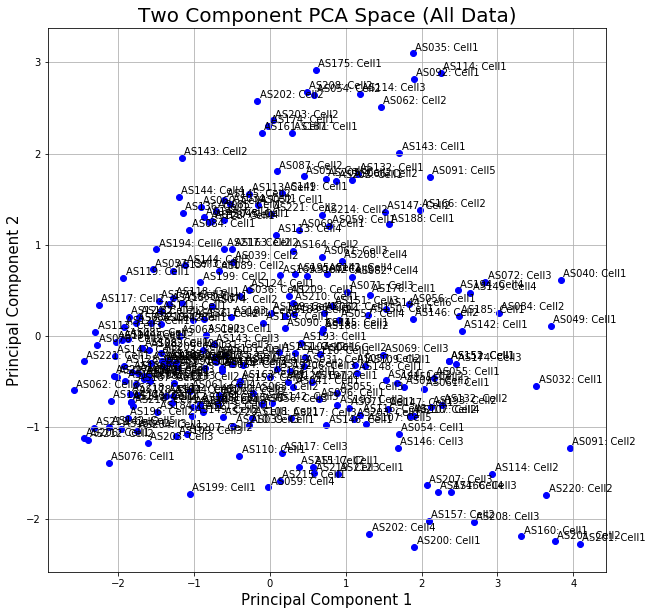

In [6]:
# Create plot of PC space (components 1/2)
P1 = PCA_components[0]
P2 = PCA_components[1]
labels = celllabels


fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(P1,P2, color='blue')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Two Component PCA Space (All Data)', fontsize = 20)
ax.grid()

for i,type in enumerate(labels):
    
    x = P1[i]
    y = P2[i]
    plt.text(x+0.03, y+0.03, type, fontsize=10)
    
    
plt.show()


Text(0, 0.5, 'Feature space for the 2nd feature')

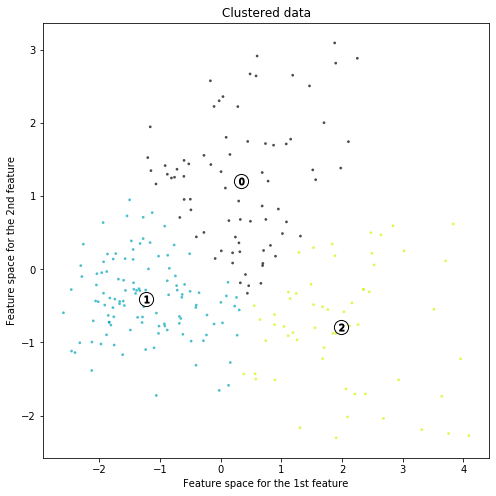

In [17]:
#K means clustering, n_clusters = 3
P1 = np.array(X_pca[:,0])
P2 = np.array(X_pca[:,1])


X = np.column_stack((P1,P2))

fig, ax1 = plt.subplots(1,1)
fig.set_size_inches(8, 8)


clusterer = KMeans(n_clusters=3, random_state=10)
cluster_labels = clusterer.fit_predict(X)

colors = cm.nipy_spectral(cluster_labels.astype(float) / 3)
ax1.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
            c=colors, edgecolor='k')

centers = clusterer.cluster_centers_
ax1.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax1.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                s=50, edgecolor='k')

ax1.set_title("Clustered data")
ax1.set_xlabel("Feature space for the 1st feature")
ax1.set_ylabel("Feature space for the 2nd feature")

In [48]:
#Rename cells to fit my convention
cellNames=np.array(df.iloc[0, 1:252])
cellNames= [i.replace('Cell1','Cell01') for i in cellNames]
cellNames= [i.replace('Cell2','Cell02') for i in cellNames]
cellNames= [i.replace('Cell3','Cell03') for i in cellNames]
cellNames= [i.replace('Cell4','Cell04') for i in cellNames]

#Dataframe of ephys clusters by cell
clusterframe= pd.DataFrame(clusterer.labels_, index = cellNames, columns=['EPhys Cluster'])
clusterframe=clusterframe.rename_axis('CellID').T
clusterframe

CellID,AS031: Cell01,AS032: Cell01,AS034: Cell01,AS035: Cell01,AS036: Cell01,AS039: Cell01,AS039: Cell02,AS040: Cell01,AS041: Cell01,AS045: Cell01,...,AS217: Cell02,AS217: Cell03,AS218: Cell01,AS219: Cell01,AS219: Cell02,AS219: Cell03,AS220: Cell01,AS220: Cell02,AS221: Cell01,AS221: Cell02
EPhys Cluster,0,2,0,0,0,1,0,2,1,0,...,0,1,1,1,1,2,1,2,1,0
